In [2]:
from datadreamer import DataDreamer
from datadreamer.llms import OpenAI
from datadreamer.steps import DataFromPrompt, Embed, CosineSimilarity, concat, HFHubDataSource
from datadreamer.embedders import SentenceTransformersEmbedder
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/Users/Justin Qiu/Desktop/NLP Research/Synthetic Data Probing/project_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with DataDreamer("./output"):
    lexical_features_dataset = HFHubDataSource(
        "Lexical Features",
        path="jjz5463/lexical-features",
        split="train"
    )


[ 🤖 DataDreamer 💤 ] Initialized. 🚀 Dreaming to folder: ./output
[ 🤖 DataDreamer 💤 ] Step 'Lexical Features' results loaded from disk. 🙌 It was previously run and saved.
[ 🤖 DataDreamer 💤 ] Done. ✨ Results in folder: ./output


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [4]:
print(lexical_features_dataset.output[0])

{'The prompts processed with the LLM.': 'Craft a unique sentence that is likely to achieve a high Flesch Reading Ease score, indicating it is very easy to read. Focus on simplicity in word choice and sentence structure. Please ensure variety in subject matter and context across all sentences generated for this category. Avoid repeating themes or structures found in other sentences within this category. Return just the sentence, no quotation marks.', 'The generations by the LLM.': 'The sun rises every morning.'}


In [5]:
with DataDreamer("./output"):
    embedded_data = Embed(
        name = "Lexical Feature Embeddings",
        inputs = {
            "texts": lexical_features_dataset.output["The generations by the LLM."]
        },
        args = {
            "embedder": SentenceTransformersEmbedder(
                model_name="AnnaWegmann/Style-Embedding"
            ),
            "truncate": True
        },
        outputs = {
            "texts": "sentences",
            "embeddings": "embeddings"
        },
    )

[ 🤖 DataDreamer 💤 ] Initialized. 🚀 Dreaming to folder: ./output
[ 🤖 DataDreamer 💤 ] Step 'Lexical Feature Embeddings' results loaded from disk. 🙌 It was previously run and saved.
[ 🤖 DataDreamer 💤 ] Done. ✨ Results in folder: ./output


In [6]:
print(np.array(embedded_data.output["embeddings"][20000:27400]).shape)

(7400, 768)


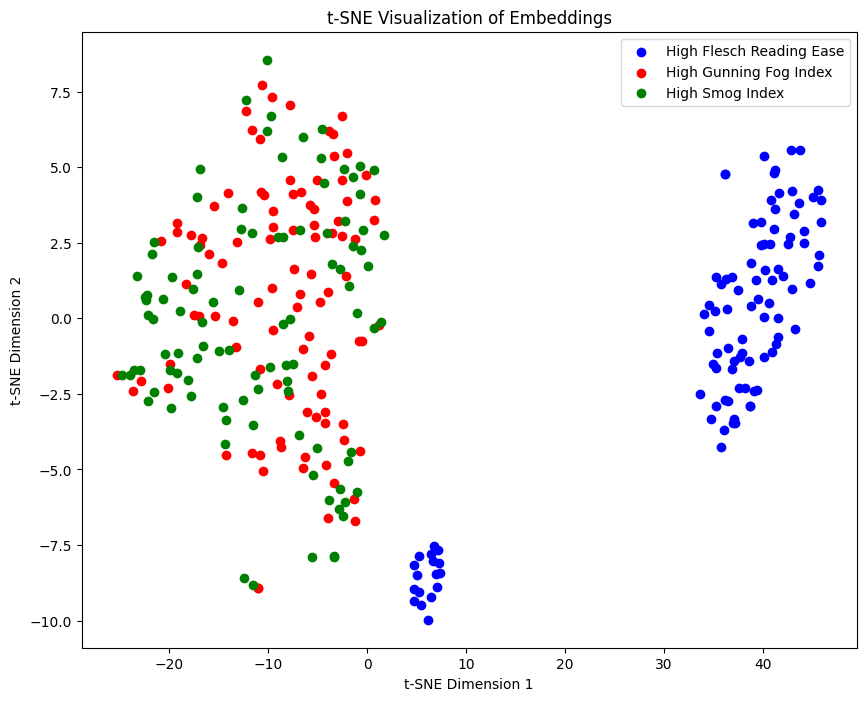

In [55]:
all_embeddings = np.array(embedded_data.output["embeddings"][0:300])

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(all_embeddings)

tsne_set1 = embeddings_tsne[:100]
tsne_set2 = embeddings_tsne[100:200]
tsne_set3 = embeddings_tsne[200:]

plt.figure(figsize=(10, 8))
plt.scatter(tsne_set1[:, 0], tsne_set1[:, 1], color='b', label='High Flesch Reading Ease')
plt.scatter(tsne_set2[:, 0], tsne_set2[:, 1], color='r', label='High Gunning Fog Index')
plt.scatter(tsne_set3[:, 0], tsne_set3[:, 1], color='g', label='High Smog Index')
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [9]:
tensor_embedded_data = torch.tensor(np.array(embedded_data.output["embeddings"][20000:27400]))
labels = []
for i in range(len(tensor_embedded_data) // 100):
    labels.extend([i] * 100)
tensor_labels = torch.tensor(labels)

dataset = TensorDataset(tensor_embedded_data, tensor_labels)

train_size = int(len(tensor_embedded_data) * 0.8)
train_dataset, val_dataset = random_split(dataset, [train_size, len(tensor_embedded_data) - train_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [35]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 768
hidden_size = 256
output_size = len(tensor_embedded_data) // 100

model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
train_losses = []
val_losses = []
accuracies = []

In [37]:
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1/200], Training Loss: 3.9263
Validation - Epoch [1/200], Loss: 3.4198, Accuracy: 15.20%
Epoch [2/200], Training Loss: 3.2414
Validation - Epoch [2/200], Loss: 3.0426, Accuracy: 20.20%
Epoch [3/200], Training Loss: 2.9362
Validation - Epoch [3/200], Loss: 2.8188, Accuracy: 24.12%
Epoch [4/200], Training Loss: 2.7136
Validation - Epoch [4/200], Loss: 2.6347, Accuracy: 26.96%
Epoch [5/200], Training Loss: 2.5478
Validation - Epoch [5/200], Loss: 2.5086, Accuracy: 31.69%
Epoch [6/200], Training Loss: 2.4198
Validation - Epoch [6/200], Loss: 2.4208, Accuracy: 32.16%
Epoch [7/200], Training Loss: 2.3109
Validation - Epoch [7/200], Loss: 2.3368, Accuracy: 34.39%
Epoch [8/200], Training Loss: 2.2153
Validation - Epoch [8/200], Loss: 2.2260, Accuracy: 38.78%
Epoch [9/200], Training Loss: 2.1426
Validation - Epoch [9/200], Loss: 2.1526, Accuracy: 39.46%
Epoch [10/200], Training Loss: 2.0699
Validation - Epoch [10/200], Loss: 2.0974, Accuracy: 39.93%
Epoch [11/200], Training Loss: 2.0031


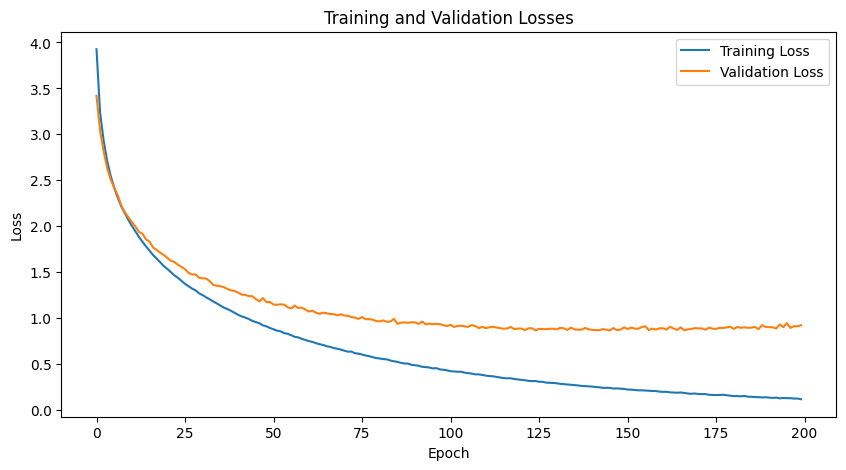

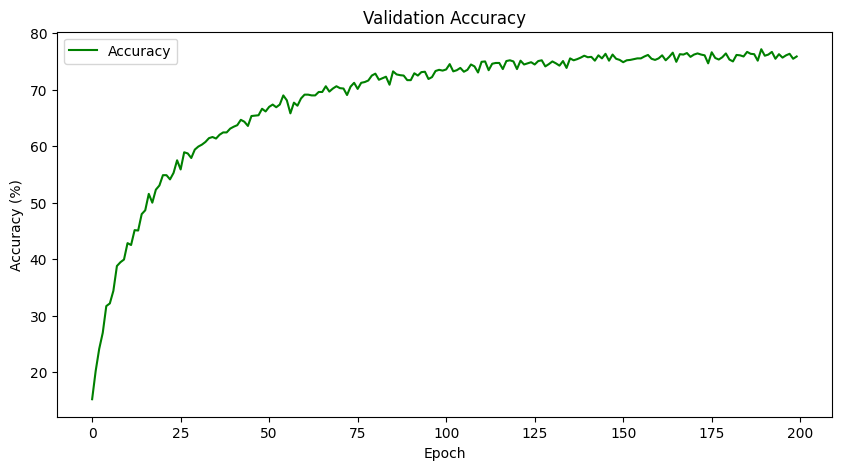

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()
